# Regression model to predict bike rental count

## Packages

In [69]:
# packages
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.1


## Dataset

In [81]:
# get dataset
dataset = pd.read_csv("./newbikes.csv")
dataset.head()

,days,hour,season,holiday,weather,temp,atemp,humidity,windspeed,real
0,68,10,1,0,3,16.4,20.455,0,11.0014,50
1,68,9,1,0,3,16.4,20.455,0,15.0013,55
2,45,1,1,0,1,12.3,12.120,42,51.9987,17
3,68,11,1,0,3,16.4,20.455,0,16.9979,46
4,346,1,4,0,1,8.2,12.880,80,0.0000,19


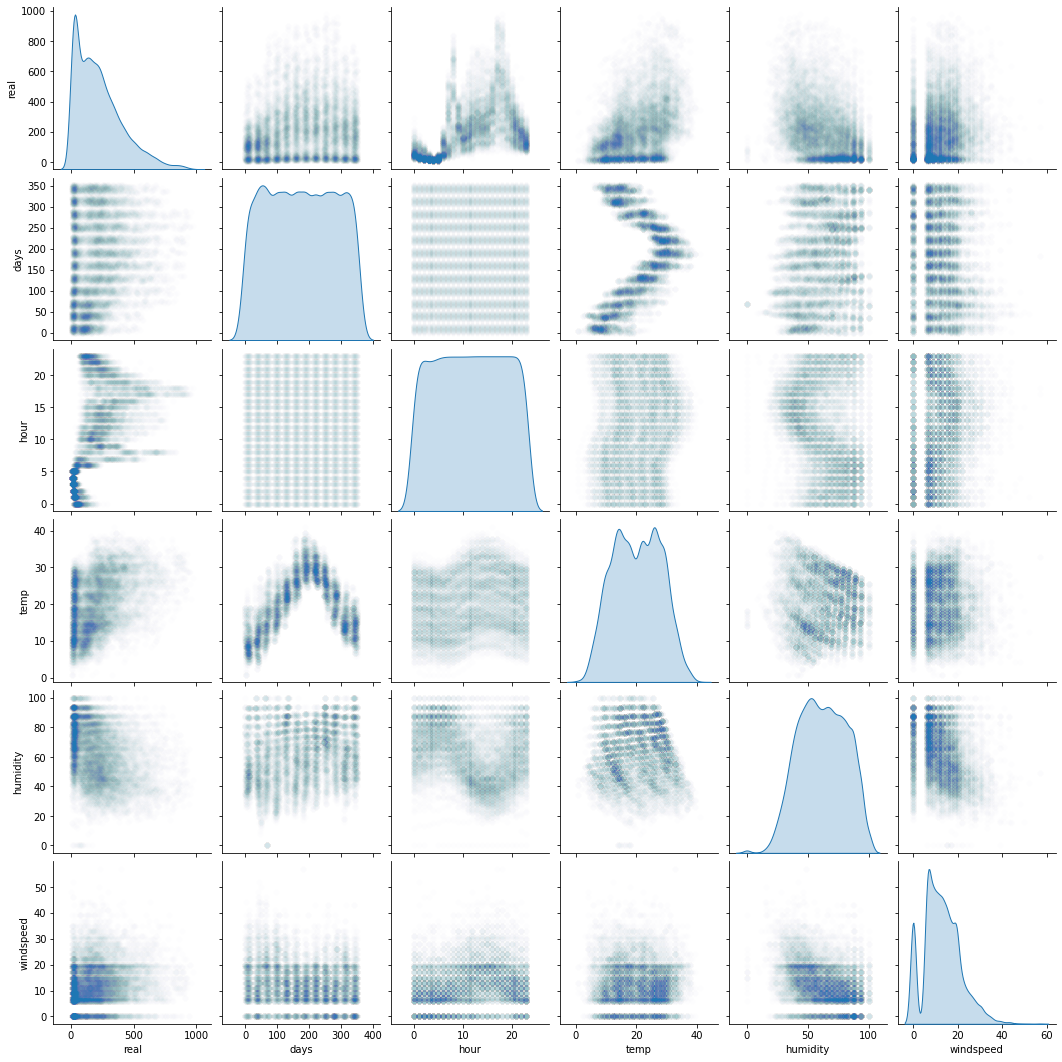

In [82]:
# find patterns among features
sns.pairplot(dataset[["real", "days", "hour", "temp", "humidity", "windspeed"]], diag_kind="kde", plot_kws={'alpha':0.0075})

In [86]:
# split dataset onto trainset and testset
train_dataset = dataset.sample(frac=0.5,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# separate features and label
train_labels = train_dataset.pop('real')
test_labels = test_dataset.pop('real')

# statistics
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

# normalization
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## Model

In [87]:
# build model
def build_model():
    model = keras.Sequential([
        layers.Dense(16, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

In [88]:
model = build_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                160       
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________


In [92]:
# train model

# Print a point (.) at the end of the each epoch to show the progress of the training.
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 50 == 0: print('')
        print('.', end='')

EPOCHS = 200
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[PrintDot()])


..................................................
..................................................
..................................................
..................................................

## Get prediction results

In [93]:
test_predictions = model.predict(normed_test_data).flatten()

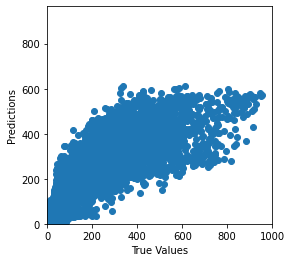

In [94]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

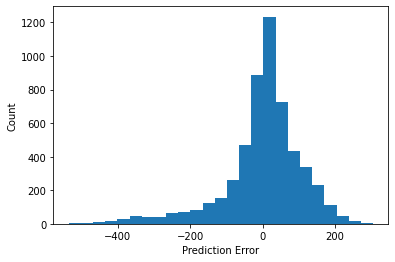

In [96]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

## Save prediction results
To demonstrate visual analytics, we get prediction results for both of test and train dataset. 

In [97]:
# get results 

dataset = pd.read_csv("./newbikes.csv")
labels = dataset.pop('real')

norm_dataset = norm(dataset)
predictions = model.predict(norm_dataset).flatten()

dataset['real'] = labels
dataset['pred'] = predictions
dataset

,days,hour,season,holiday,weather,temp,atemp,humidity,windspeed,real,pred
0,68,10,1,0,3,16.40,20.455,0,11.0014,50,199.589615
1,68,9,1,0,3,16.40,20.455,0,15.0013,55,188.562317
2,45,1,1,0,1,12.30,12.120,42,51.9987,17,-10.677078
3,68,11,1,0,3,16.40,20.455,0,16.9979,46,201.650192
4,346,1,4,0,1,8.20,12.880,80,0.0000,19,6.410714
...,...,...,...,...,...,...,...,...,...,...,...
10881,288,17,4,0,1,21.32,25.000,39,12.9980,956,497.983826
10882,282,17,4,0,1,23.78,27.275,43,15.0013,917,508.160889
10883,253,17,3,0,1,28.70,31.820,28,0.0000,945,582.014526
10884,252,18,3,0,1,25.42,31.060,35,19.9995,953,573.917236


In [98]:
# save the df as a csv file
dataset.to_csv('./newresults.csv', sep=',', na_rep='NaN')

In [99]:
# save the keras model
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, './model')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)
